# Environment monitor

This notebook is the environment monitor. It will log all readings to Adafruit IO and show readings on the LCD screen.

In [ ]:
import time
import ST7735
from ltr559 import LTR559
from bme280 import BME280
from PIL import Image, ImageDraw, ImageFont
from fonts.ttf import RobotoMedium as UserFont
from IPython.display import clear_output, display, update_display
import matplotlib.pyplot as plt



In [ ]:
import json
from Adafruit_IO import Client, Feed, RequestError

In [ ]:
ADAFRUIT_IO_USERNAME = "tproffen"
ADAFRUIT_IO_KEY = "ed44b8031ec34d1fb2eda6f4d8a0c832"

In [ ]:
# Create an instance of the REST client.
aio = Client(ADAFRUIT_IO_USERNAME, ADAFRUIT_IO_KEY)

In [ ]:
# BME280 temperature/pressure/humidity sensor
bme280 = BME280()

In [ ]:
# Proximity/Light sensor
ltr559 = LTR559()

In [ ]:
# Setting up the LCD display
disp = ST7735.ST7735(port=0,cs=1,dc=9,backlight=12,rotation=270,spi_speed_hz=10000000)
disp.begin()

back_color = (0, 60, 20)
text_color = (255, 255, 255)
head_color = (255, 255,   0)
warn_color = (255,  50,  50)
font_size  = 14
text_margin= 5

img = Image.new('RGBA', (disp.width, disp.height))
draw = ImageDraw.Draw(img)
font = ImageFont.truetype(UserFont, font_size)
size_x, size_y = draw.textsize('text', font)

#### Some useful functions

Getting the feed id from Adafruit IO.

In [ ]:
def getFeed(name):
    try:
        feedID = aio.feeds(name)
    except RequestError:
        feed = Feed(name=name)
        feedID = aio.create_feed(feed)
    return feedID

Updating the LCD screen with readings.

In [ ]:
def updateLCD(t,h,p): 
    tstr="Temperature: {0:.1f} C".format(t)
    hstr="Humidity: {0:.1f} %".format(h)
    pstr="Pressure: {0:.1f} hPa".format(p)
    
    draw.rectangle((0, 0, disp.width, disp.height), back_color)
    draw.text((text_margin, text_margin), "ORCSPICamp Station", font=font, fill=head_color)
    draw.text((text_margin, text_margin+2.0*size_y), tstr, font=font, fill=text_color)
    draw.text((text_margin, text_margin+3.0*size_y), hstr, font=font, fill=text_color)
    draw.text((text_margin, text_margin+4.0*size_y), pstr, font=font, fill=text_color)

    disp.display(img)

In notebook plotting of measured data.

In [ ]:
# Array for local data to plot
tdata=[]
hdata=[]
pdata=[]

def updatePlot(t,h,p):
    tdata.append(t)
    hdata.append(h)
    pdata.append(p)
    positions = range(len(tdata));
    
    plt.clf();
    plt.figure(figsize=(10, 8))
    plt.subplot(311);
    plt.ylabel("Temperature (C)")
    plt.plot(positions, tdata);
    plt.subplot(312);
    plt.ylabel("Humidity (%)")
    plt.plot(positions, hdata);
    plt.subplot(313);
    plt.ylabel("Pressure (hPa)")
    plt.plot(positions, pdata);
    
    display(plt.gcf()); 


## Main loop

This is the main loop reading values and sending them to the cloud and updating the LCD display. Press Control-C to abort of click the stop button.

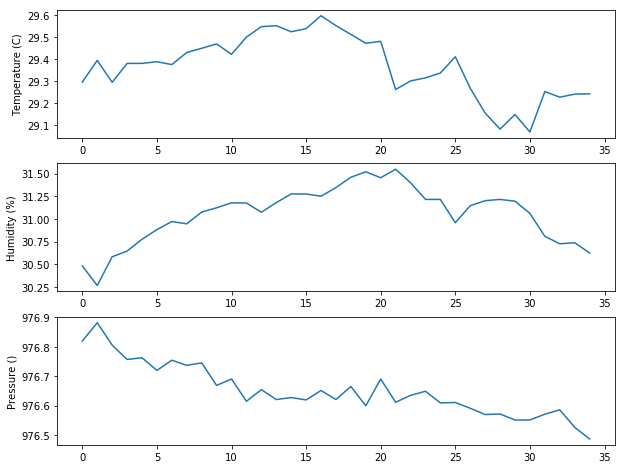

In [71]:
# Get feeds
tempFeed = getFeed("temperature")
humidFeed = getFeed("humidity")
pressFeed = getFeed("pressure")
lightFeed = getFeed("brightness")

# Set metadata associated with our measurement station
metadata = {'lat': 36.010357,
            'lon': -84.269646,
            'ele': 850,
            'created_at': None}

# Time between readings
delay = 20

# The main loop
while True:
    # Read pressure
    p = bme280.get_pressure()
    t = bme280.get_temperature()
    h = bme280.get_humidity()
    l = ltr559.get_lux()
    
    clear_output(wait=True)
    updatePlot(t,h,p)
    updateLCD(t,h,p)

    out="T: {0:.1f} C - Humidity: {1:.1f} % - Pressure: {2:.0f} hPa".format(t,h,p)
    print(out)
    
    aio.send_data(tempFeed.key,  t, metadata)
    aio.send_data(humidFeed.key, h, metadata)
    aio.send_data(pressFeed.key, p, metadata)
    aio.send_data(lightFeed.key, l, metadata)
    
    time.sleep(delay)
